# Kerékpárbérlés ELőrejelzés

projekt célja a napi kerékpárbérlések számának előrejelzése egy városi bike-sharing rendszerben.  
Az adathalmaz tartalmazza az időjárási körülményeket, a naptári jellemzőket és a felhasználói viselkedést.  
A cél egy olyan regressziós modell felépítése, ami képes kezelni az időbeli mintázatokat és jól általánosít különböző évszakok között.

A teljes folyamat lépései:
- Adatmegismerés és feltáró elemzés (EDA)  
- Feature engineering (új jellemzők képzése, szinusz–koszinusz transzformációk)  
- Modellépítés `HistGradientBoostingRegressor` segítségével  
- Modellértékelés és interpretálhatóság SHAP elemzéssel
- Majd a modell tuningolása és optimalizálása

### Az adat megismerése
Az adathalmaz 2011–2012 közötti napi és órás kerékpárbérlési adatokat tartalmaz (Jelenleg most csak a naposat használom, de előkészítettem az órás adatokat, későbbi felhasználásra).  
Minden sor egy adott naphoz tartozó összesített bérlésszámot (`cnt`) reprezentálja, amit két részre bontottak: `casual` és `registered` felhasználók.  
Az időjárási adatok (hőmérséklet, páratartalom, szélsebesség) mellett naptári jellemzők (évszak, hónap, nap, munkanap) is megtalálhatók.

### Adatforrás
A projekt a [Bike Sharing Dataset (Kaggle)](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset) adataira épül.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
import shap

In [ ]:
df_daily =  pd.read_csv('./data/day.csv', index_col=0)
df_intraday = pd.read_csv('./data/hour.csv', index_col=0)

In [ ]:
df_daily.head(3)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


In [ ]:
df_daily.shape

(731, 15)

In [ ]:
df_daily.isna().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [ ]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 1 to 731
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      731 non-null    object 
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.4+ KB


In [ ]:
df_daily['dteday'] = pd.to_datetime(df_daily['dteday'])
df_intraday['dteday'] = pd.to_datetime(df_intraday['dteday'])

In [ ]:
df_intraday.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
df_intraday.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   yr          17379 non-null  int64         
 3   mnth        17379 non-null  int64         
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  int64         
 6   weekday     17379 non-null  int64         
 7   workingday  17379 non-null  int64         
 8   weathersit  17379 non-null  int64         
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float

## Napi adatok elemzése (EDA)

### Szezonális trendek
- A napi bérlések száma erősen szezonális mintázatot mutat: tavasszal és nyáron folyamatosan emelkedik, míg télen visszaesik.  
  (*Rented bikes over the first year* és *Rented bikes by season* grafikonok)
- A regisztrált felhasználók aránya jelentősen magasabb az alkalmi bérlőkéhez képest, azonban nyáron a nem regisztrált („casual”) bérlések aránya is megugrik.  
  (*Casual vs Registered users*)

### Időjárási hatások
- A hőmérséklet és a bérlések között erős pozitív korreláció figyelhető meg (*Temperature vs Rentals*).  
- A páratartalom és a szélsebesség negatívan hat a bérlések számára (*Feature correlation with rentals*).  
- A téli hónapokban a bérlések száma jelentősen visszaesik, valószínűleg a hideg és veszélyes közlekedési körülmények miatt (*Rented bikes by season*).

### Naptári mintázatok
- Ünnepnapokon jellemzően kevesebben veszik igénybe a bérlési szolgáltatást, mivel sokan nem dolgoznak és kevesebbet közlekednek (*Rentals holiday and non-holiday*).  
- A nyári hónapokban és hétvégéken magasabb a kereslet, ami a szabadidős használathoz köthető.  

### Korrelációk és eloszlások
- A `registered` és a teljes `cnt` között közel lineáris kapcsolat figyelhető meg (*Registered users and rented bikes*).  
- A `cnt` eloszlása közel normális, enyhe jobbra ferdeséggel (*Distribution of rented bikes*).  
- A hőmérséklet (`temp`, `atemp`) erős pozitív korrelációban van a bérlésszámmal, ami várhatóan jó prediktor lesz.  
- A `casual` és `registered` változók önmagukban is nagy korrelációt mutatnak a célváltozóval, de ezek közvetlen használata adat-szivárgást okozhat, ezért a modellezés során elhagyom őket.

 

### Összegzés
Az EDA alapján a bérlések száma elsősorban **szezonális**, **időjárási** és **felhasználói típusokhoz kapcsolódó** tényezőktől függ.  
A hőmérséklet és a szezon a legerősebb előrejelzők, míg a páratartalom és a szélsebesség negatív hatású tényezők.


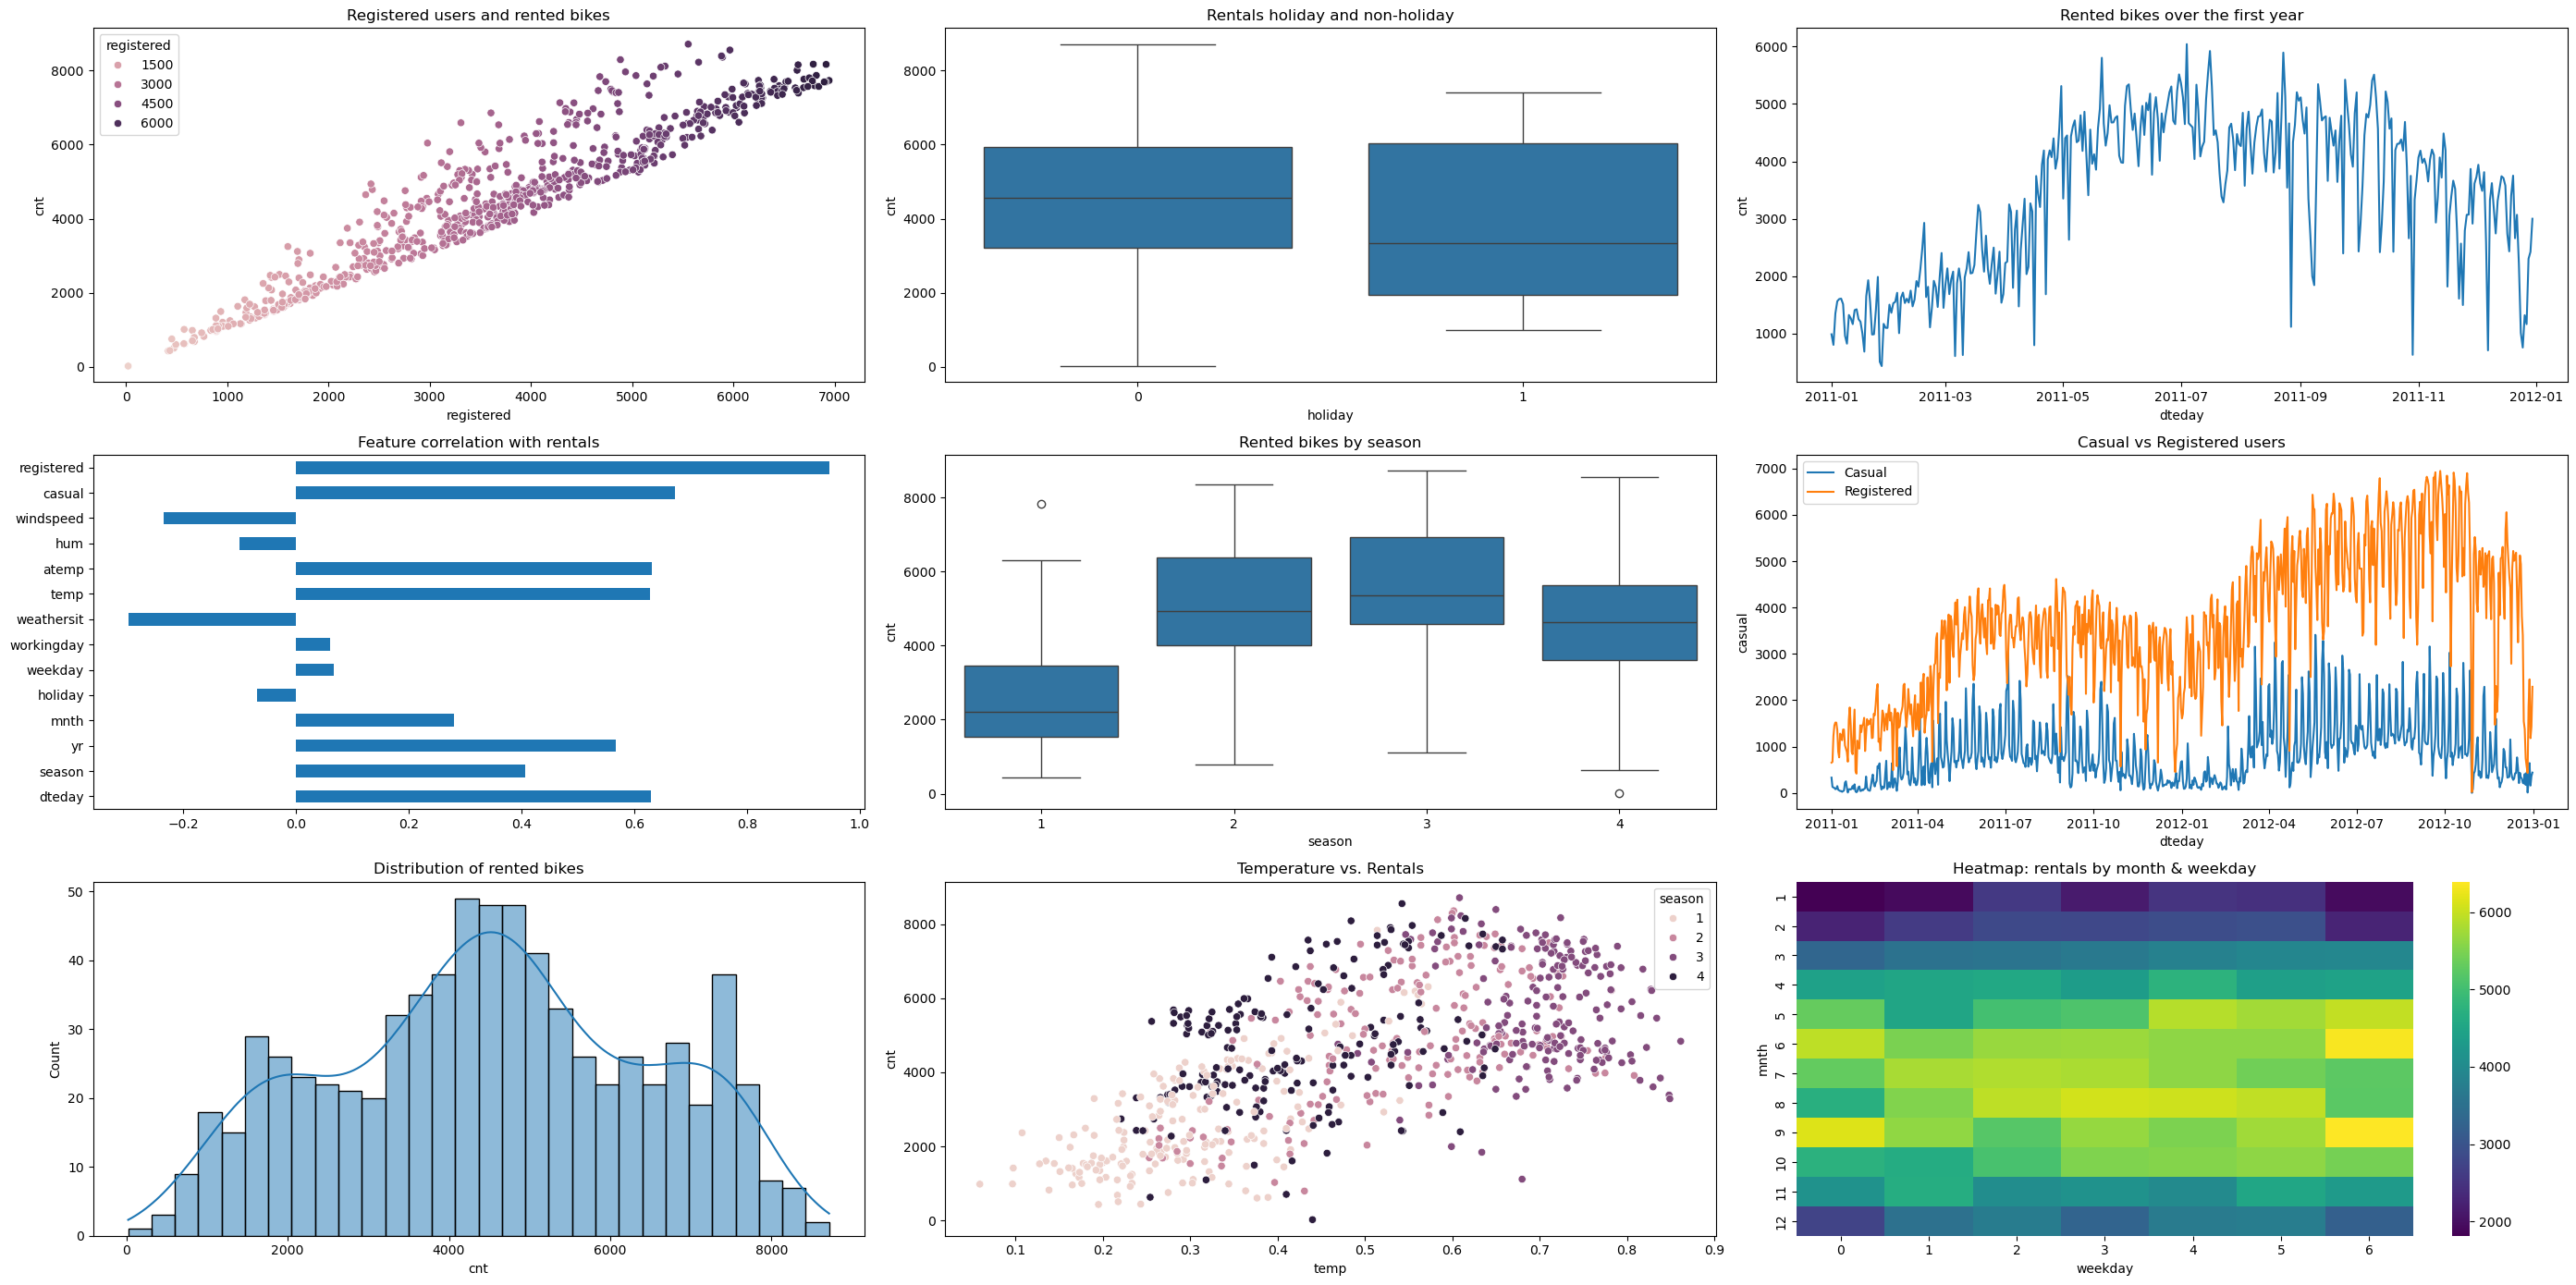

In [ ]:
f, ax = plt.subplots(3, 3, figsize=(28,14))



sns.scatterplot(data=df_daily, x='registered', y='cnt', hue='registered', ax=ax[0, 0])
ax[0, 0].set_title('Registered users and rented bikes')

sns.boxplot(data=df_daily, x='holiday', y='cnt', ax=ax[0,1])
ax[0, 1].set_title('Rentals holiday and non-holiday')
ax[1,0].set_xlabel('Holiday (0=No, 1=Yes)')

sns.lineplot(data=df_daily[0:364], x='dteday', y='cnt', ax=ax[0, 2])
ax[0, 2].set_title("Rented bikes over the first year")

corr = df_daily.corr()['cnt'].drop('cnt')
corr.plot(kind='barh', ax=ax[1,0])
ax[1,0].set_title('Feature correlation with rentals')


sns.boxplot(x='season', y='cnt', data=df_daily, ax=ax[1,1])
ax[1,1].set_title('Rented bikes by season')

sns.lineplot(data=df_daily, x='dteday', y='casual', ax=ax[1,2], label="Casual")
sns.lineplot(data=df_daily, x='dteday', y='registered', ax=ax[1,2], label="Registered")
ax[1, 2].set_title("Casual vs Registered users")
ax[1,2].legend()


sns.histplot(df_daily['cnt'], kde=True, bins=30, ax=ax[2,0])
ax[2,0].set_title('Distribution of rented bikes')

sns.scatterplot(x='temp', y='cnt', hue='season', data=df_daily, ax=ax[2,1])
ax[2,1].set_title('Temperature vs. Rentals')


pivot = df_daily.pivot_table(values='cnt', index='mnth', columns='weekday', aggfunc='mean')
sns.heatmap(pivot, cmap='viridis', ax=ax[2,2])
ax[2,2].set_title('Heatmap: rentals by month & weekday')


plt.tight_layout()
plt.show()

## EDA – Óránkénti adatok (Intraday)

### Időbeli trendek
- Az óránkénti bérlési adatok erős szezonális mintázatot mutatnak, a tavaszi és nyári hónapokban jelentősen magasabb kereslettel.  
  (*Total rentals over time*, *Average rentals by month*.)
- A napi mintázatban két egyértelmű csúcs látható: reggel és késő délután, ami a munkába járás és hazatérés időszakát tükrözi.  
  (*Rentals by weekday and hour*.)
- Az év második felében a bérlések száma fokozatosan emelkedik, ami a szolgáltatás elterjedését vagy a felhasználói bázis növekedését jelezheti.

### Felhasználói viselkedés
- A *Casual vs Registered rentals by hour* grafikon alapján két jól elkülönülő használati minta figyelhető meg:  
  - A **regisztrált** felhasználók főként a reggeli (8–9 óra) és délutáni (17–18 óra) csúcsidőben aktívak.  
  - Az **alkalmi** felhasználók inkább délután és hétvégén vesznek igénybe kerékpárt.  
- Ez arra utal, hogy a regisztrált felhasználók többsége munkába járási céllal használja a rendszert, míg az alkalmi felhasználók elsősorban szabadidős tevékenységhez kötik a bérlést.

### Szezonalitás és naptári hatások
- A *Seasonality Trends* boxplot egyértelműen mutatja, hogy a kereslet a tavaszi és nyári időszakban a legmagasabb, míg télen jelentősen csökken.  
- A *Rentals on working vs non-working days* ábra megerősíti, hogy a munkanapokon több bérlés történik, ami összhangban van a napi közlekedési mintázatokkal.

### Időjárási hatások
- A *Temperature vs Rentals* ábra szerint a hőmérséklet emelkedésével nő a bérlések száma egészen egy közepes értékig (~0.6 normalizált érték), ezután a hatás telítődik.  
- A *Humidity vs Rentals* gyenge negatív összefüggést mutat: a magas páratartalomhoz alacsonyabb bérlésszám társul.  
- Összességében a kellemes, száraz időjárás ösztönzi leginkább a kerékpárhasználatot, míg a túl hideg vagy párás napok visszafogják a keresletet.

### Havi szezonalitás
- Az *Average rentals by month* grafikon alapján a bérlések száma június és szeptember között tetőzik,  
  míg januárban és februárban a legalacsonyabb.  
- Ez a mintázat megerősíti a hosszú távú szezonális trendet, amit a napi adatokban is láthattunk.

### Korrelációk
- A *Correlation heatmap* alapján a hőmérséklet (`temp`, `atemp`) erős pozitív kapcsolatban áll a bérlésszámmal (`cnt`).  
- Az időjárási tényezők (`hum`, `windspeed`) gyenge negatív korrelációt mutatnak.  
- Az órára, munkanapra és hét napjára vonatkozó jellemzők kevésbé korrelálnak közvetlenül a bérlésszámmal,  
  ami arra utal, hogy az időjárási és szezonalitási tényezők magyarázzák a változások nagy részét.

### Összegzés
Az óránkénti adatok elemzése rávilágít arra, hogy a bérlések dinamikáját elsősorban a **munkába járási szokások**,  
az **évszakok** és az **időjárási körülmények** alakítják.  
A rendszerhasználat két fő mintázat köré szerveződik: a **rendszeres, munkaidőhöz kötött használat** és a **szabadidős, alkalmi aktivitás**.  
Ezek a felismerések irányt mutatnak a későbbi feature engineering során, különösen a ciklikus időjellemzők és időjárási interakciók beépítése terén.


C:\Users\sascs\AppData\Local\Temp\ipykernel_18532\4009501325.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\sascs\AppData\Local\Temp\ipykernel_18532\4009501325.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mnth', y='cnt', data=monthly, palette='mako', ax=ax[2,1])


Text(0.5, 1.0, 'Correlation heatmap for all features')

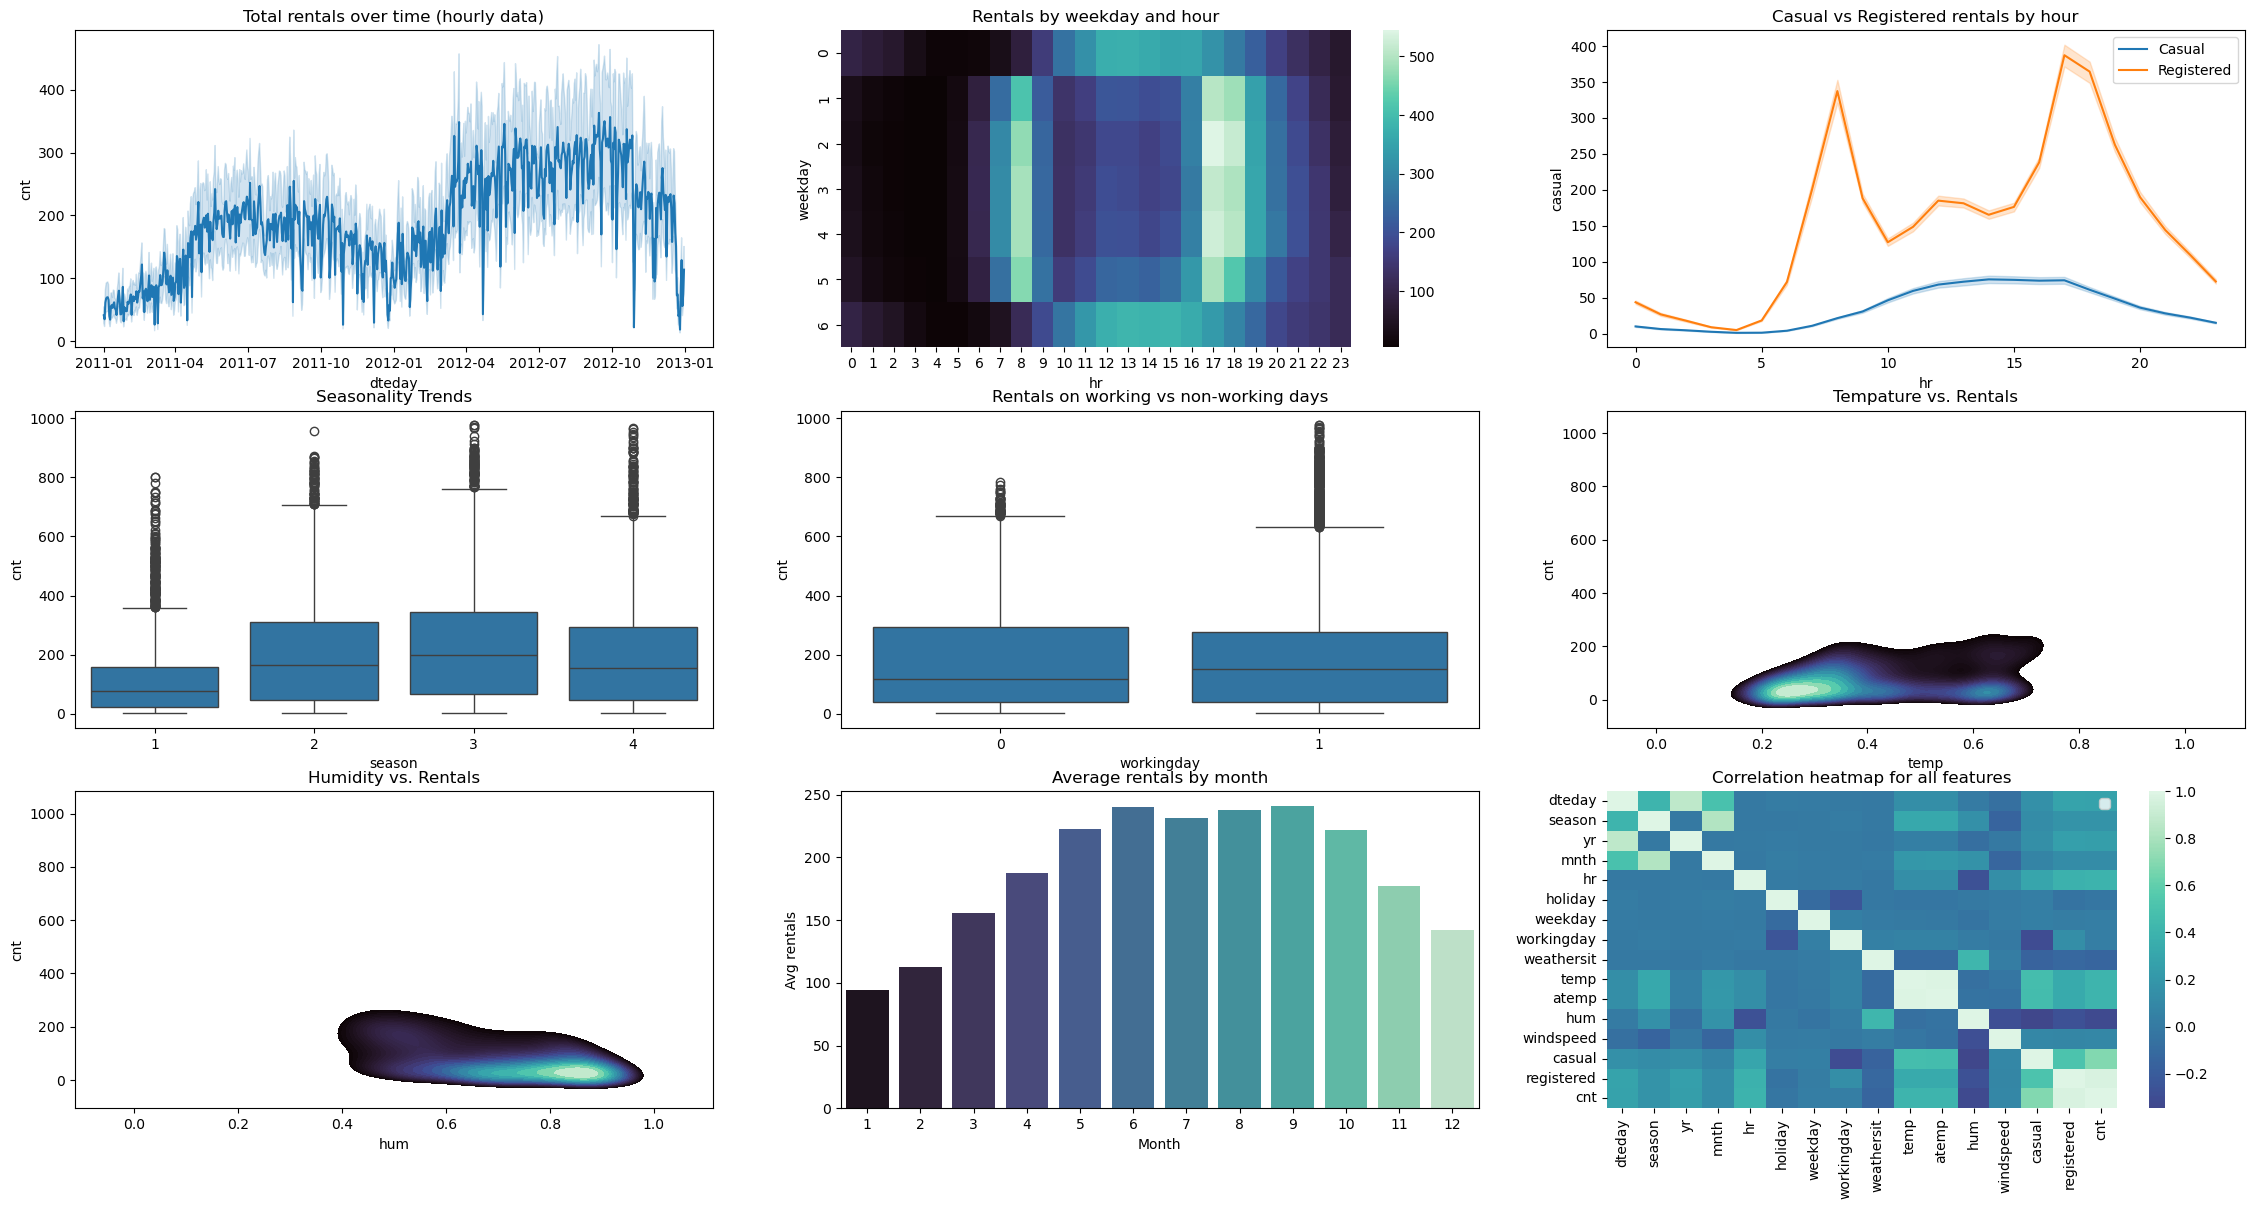

In [ ]:
f, ax = plt.subplots(3, 3, figsize=(28,14))

sns.lineplot(x='dteday', y='cnt', data=df_intraday, ax=ax[0,0])
ax[0,0].set_title('Total rentals over time (hourly data)')


pivot = df_intraday.pivot_table(values='cnt', index='weekday', columns='hr', aggfunc='mean')
sns.heatmap(pivot, cmap='mako', ax=ax[0,1])
ax[0,1].set_title('Rentals by weekday and hour')


sns.lineplot(x='hr', y='casual', data=df_intraday, label='Casual', ax=ax[0,2])
sns.lineplot(x='hr', y='registered', data=df_intraday, label='Registered', ax=ax[0,2])
ax[0,2].set_title('Casual vs Registered rentals by hour')
plt.legend()


sns.boxplot(x='season', y='cnt', data=df_intraday, ax=ax[1,0])
ax[1,0].set_title("Seasonality Trends")


sns.boxplot(data=df_intraday, x='workingday', y='cnt', ax=ax[1,1])
ax[1,1].set_title("Rentals on working vs non-working days")

sns.kdeplot(df_intraday, x='temp', y='cnt', fill=1, thresh=.5, levels=30, cmap='mako', ax=ax[1,2])
ax[1,2].set_title("Tempature vs. Rentals")



sns.kdeplot(x='hum', y='cnt', data=df_intraday, fill=1, thresh=.5, levels=30, cmap='mako', ax=ax[2,0])
ax[2,0].set_title('Humidity vs. Rentals')

monthly = df_intraday.groupby('mnth')['cnt'].mean().reset_index()
sns.barplot(x='mnth', y='cnt', data=monthly, palette='mako', ax=ax[2,1])
ax[2,1].set_title('Average rentals by month')
ax[2,1].set_xlabel('Month')
ax[2,1].set_ylabel('Avg rentals')

sns.heatmap(df_intraday.corr(), cmap='mako', center=0, ax=ax[2,2])
ax[2,2].set_title('Correlation heatmap for all features')


## Feature Engineering

### Cél
A célom az volt, hogy olyan új jellemzőket hozzak létre, amik jobban leírják a szezonális és időjárási hatásokat, és segítenek a modellnek pontosabban tanulni. Emellett fontos volt, hogy minden átalakítás Pipeline-ban történjen, hogy a folyamat átlátható és reprodukálható legyen.

### Alap jellemzők és kizárások
A modellhez megtartottam a legfontosabb numerikus és kategóriás változókat:
- Numerikus: `temp`, `atemp`, `hum`, `windspeed`
- Kategóriás: `season`, `yr`, `holiday`, `workingday`, `weathersit`

A `casual` és `registered` oszlopokat nem használtam, mert ezek már tartalmazzák a célváltozó (`cnt`) információját, és **data leakage-et** okoznának. A `dteday` oszlopot is eltávolítottam, mert csak az időpontot jelzi, és a ciklikus formát használom helyette.

### Ciklikus kódolás
Az időalapú jellemzők (nap, hónap, óra) ciklikusan ismétlődnek, ezért nem jó őket sima számként kezelni. Például a „7. nap” és a „0. nap” egymás mellett vannak, de numerikusan nagyon messze. Ezt javítottam sinus–cosinus átalakítással.

- Napi adatoknál: `weekday` → `sin_wd`, `cos_wd`, `mnth` → `sin_mnth`, `cos_mnth`  
- Órás adatoknál: `hr` → `sin_hr`, `cos_hr`, `weekday` és `mnth` ugyanúgy, mint fent

A `sin` és `cos` értékekkel a modell (A mostani esetben **HistGradientBoostingRegressor**) könnyebben felismeri az ismétlődő mintázatokat, mert a jellemzők folytonosan írják le az időt, nem pedig kategorikus lépésekben.  

**Forrás:**  
[Bansal, A., Balaji, K., & Lalani, Z. (2025). *Temporal Encoding Strategies for Energy Time Series Prediction.*](https://arxiv.org/pdf/2503.15456)


### Új jellemzők és interakciók
A baseline modellhez néhány egyszerű, de hasznos új jellemzőt hoztam létre:
- Nemlinearitás: `temp_sq = temp^2`, `atemp_sq = atemp^2`
- Interakciók: `temp_hum = temp * hum`, `temp_wind = temp * windspeed`
- Komfortérzet: `comfort_diff = atemp - temp`
- Szabadnap jelző: `is_weekend = weekday ∈ {5,6}`

Ezekkel az új oszlopokkal a modell jobban meg tudja érteni az időjárás és az emberi viselkedés kapcsolatát.

### SHAP alapján finomítás
A SHAP elemzés után megnéztem, mely jellemzők járultak hozzá leginkább az előrejelzéshez. Néhány kevésbé hasznos változót kivettem (például `temp_hum`, `is_weekend`), mert nem növelték a teljesítményt. A hőmérséklethez kapcsolódó jellemzők (`temp`, `atemp`) és az időalapú ciklikus jellemzők (`sin_mnth`, `cos_mnth`, `sin_wd`, `cos_wd`) maradtak a legerősebbek. A szél és a páratartalom negatív hatása is egyértelműen látszott, ezért ezek maradtak a modellben.

### Pipeline előnyei
Az egész átalakítási folyamatot Pipeline-ban raktam össze, mert így nincs adat-szivárgás a tanító és a teszt adatok között, minden lépés ugyanúgy lefut a tanításkor és a predikciónál is, a kód pedig sokkal átláthatóbb és könnyebben újrahasznosítható.

### Összegzés
A feature engineering után a modell jobban felismeri az időbeli ismétlődéseket (nap, hónap, óra), jobban kezeli a nemlineáris időjárási hatásokat, és kevesebb, de informatívabb jellemzőt használ. A SHAP alapján tisztított verzió stabilabb és pontosabb lett, és jól előkészíti az adatokat a következő lépésre: a modell tanításra és értékelésre.


In [ ]:
TARGET = 'cnt'
drop_cols = ['casual','registered','dteday']   # leakage + dátum
cats_day  = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
cats_hour = cats_day + ['hr']

In [ ]:
def fe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    try:
        df['temp_sq'] = np.pow(df['temp'], 2)
        df['atemp_sq'] = np.pow(df['atemp'], 2)
        
        
        df['temp_hum'] = df['temp'] * df['hum']
        df['temp_wind'] = df['temp'] * df['windspeed']
        
        df['comfort_diff'] = df['atemp'] - df['temp']
        
        
        df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
        
        if 'hr' in df.columns:
            df['sin_hr'] = np.sin(2 *  np.pi * df['hr'] / 24)
            df['cos_hr'] = np.cos(2 *  np.pi * df['hr'] / 24)
            
        
        df['sin_wd'] = np.sin(2 * np.pi * df['weekday'] / 7)
        df['cos_wd'] = np.cos(2 * np.pi * df['weekday'] / 7)
        
        df['sin_mnth'] = np.sin(2 * np.pi * df['mnth'] / 12)
        df['cos_mnth'] = np.cos(2 * np.pi * df['mnth'] / 12)
    except:
        print("An Error Occured")
    return df

In [ ]:
# Daily PipeLine

X_day = df_daily.drop(columns=drop_cols+[TARGET]).copy()
y_day = df_daily[TARGET].copy()

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore',sparse_output=False), cats_day)
    ], remainder='passthrough')

pipe = Pipeline([
    ('fe', FunctionTransformer(fe, validate=False)),
    ("prep", pre),
    ("model", HistGradientBoostingRegressor(
        random_state=42,
        max_depth=9,
        min_samples_leaf=95,
        learning_rate=0.25
        ))
])



In [ ]:
split_day = '2012-10-01'

train = df_daily[df_daily['dteday'] < split_day]
test = df_daily[df_daily['dteday'] >= split_day]

X_train = train.drop(columns=['cnt', 'casual', 'registered', 'dteday'])
y_train = train['cnt']
X_test  = test.drop(columns=['cnt', 'casual', 'registered', 'dteday'])
y_test  = test['cnt']

In [ ]:
pipe.fit(X_train, y_train)

,steps,"[('fe', ...), ('prep', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function fe ...00291936EB9C0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# acc_score = accuracy_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R2:   {r2:.3f}")
# print(f"Accuracy:   {acc_score:.3f}")

RMSE: 1058563.20
MAE:  787.41
R2:   0.713


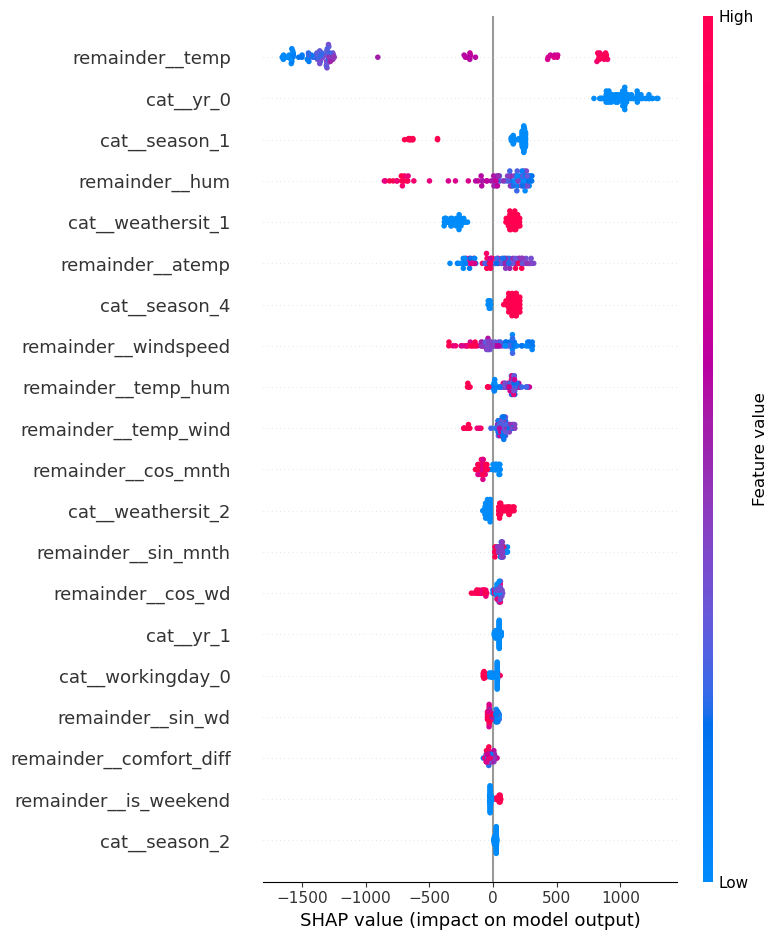

In [ ]:
model = pipe.named_steps['model']
X_fe = pipe.named_steps['fe'].transform(X_test.copy())
X_trans = pipe.named_steps['prep'].transform(X_fe)
feature_names = pipe.named_steps['prep'].get_feature_names_out()


explainer = shap.Explainer(model)
shap_values = explainer(X_trans)

shap.summary_plot(shap_values, X_trans, feature_names=feature_names)


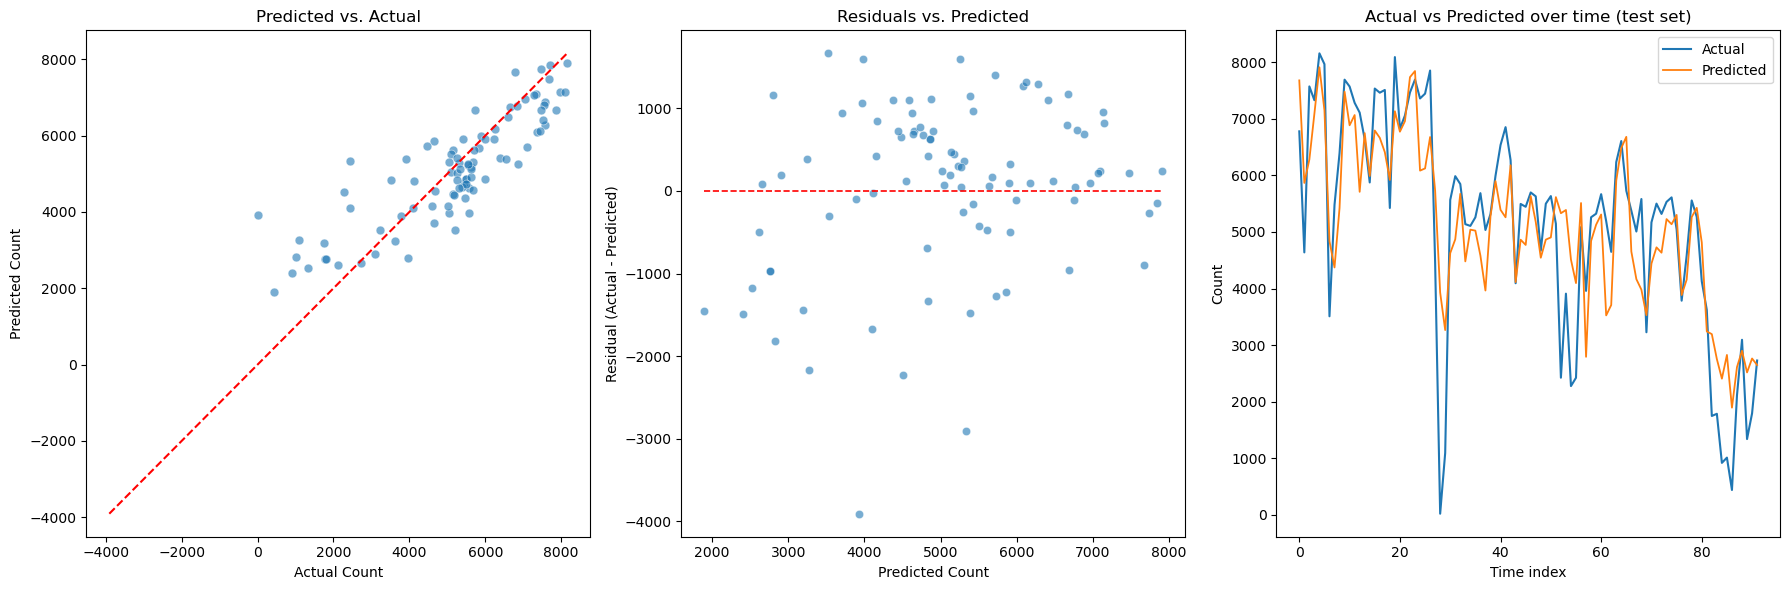

In [ ]:
results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
results['Residuals'] = results['Actual'] - results['Predicted']


f, ax = plt.subplots(1,3, figsize=(18,6))

sns.scatterplot(data=results, x="Actual", y="Predicted", alpha=.6, s=40, ax=ax[0])
sns.lineplot(x=[results.min().min(), results.max().max()],
             y=[results.min().min(), results.max().max()],
             color='red', linestyle='--', ax=ax[0])
ax[0].set_title('Predicted vs. Actual')
ax[0].set_xlabel("Actual Count")
ax[0].set_ylabel("Predicted Count")

sns.scatterplot(data=results, x='Predicted', y="Residuals", alpha=.6, ax=ax[1])   
sns.lineplot(x=[results["Predicted"].min(), results["Predicted"].max()], y=[0,0], color='red', linestyle='--', linewidth=1.2, ax=ax[1])
ax[1].set_title('Residuals vs. Predicted')
ax[1].set_xlabel("Predicted Count")
ax[1].set_ylabel("Residual (Actual - Predicted)")


sns.lineplot(x=range(len(y_test)), y=y_test, label='Actual', linewidth=1.5, ax=ax[2])
sns.lineplot(x=range(len(y_test)), y=y_pred, label='Predicted', linewidth=1.3, ax=ax[2])
ax[2].set_title('Actual vs Predicted over time (test set)')
ax[2].set_xlabel('Time index')
ax[2].set_ylabel('Count')


ax[2].legend()
plt.tight_layout()
plt.show()

temp_bin
(0.3, 0.4]       34
(0.2, 0.3]       24
(0.4, 0.5]       18
(0.5, 0.6]       13
(0.6, 0.7]        3
(-0.001, 0.1]     0
(0.1, 0.2]        0
(0.7, 0.8]        0
(0.8, 0.9]        0
(0.9, 1.0]        0
Name: count, dtype: int64


C:\Users\sascs\AppData\Local\Temp\ipykernel_18532\848521679.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_by_temp = errors.groupby('temp_bin')['abs_err'].mean()


<Axes: xlabel='temp', ylabel='None'>

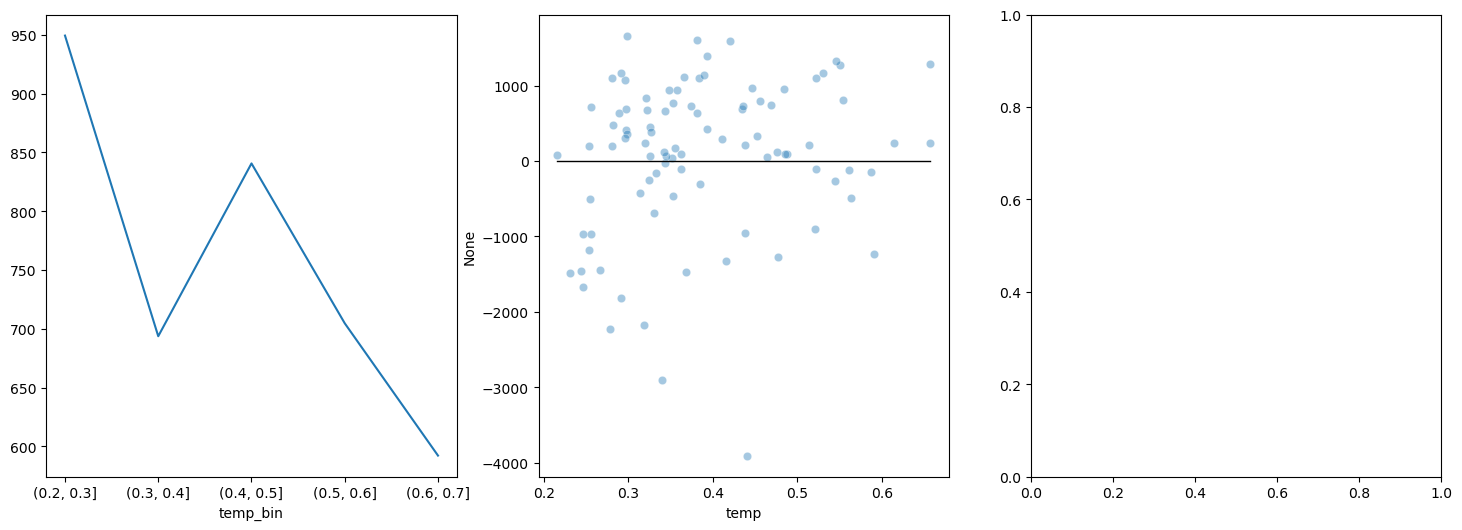

In [ ]:
errors = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'temp': X_test['temp'].values
}, index=X_test.index)

errors = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'temp': X_test['temp'].values
}, index=X_test.index)

errors['abs_err'] = (errors['y_true'] - errors['y_pred']).abs()


bins = np.linspace(0,1,11)
errors['temp_bin'] = pd.cut(errors['temp'], bins=bins, include_lowest=True) # type: ignore

mae_by_temp = errors.groupby('temp_bin')['abs_err'].mean()

f, ax = plt.subplots(1,3, figsize=(18,6))

sns.lineplot(x=mae_by_temp.index.astype(str), y=mae_by_temp.values, markers="o", ax=ax[0])

print(errors['temp_bin'].value_counts())
sns.scatterplot(x=errors['temp'], y=(errors['y_true'] - errors['y_pred']), alpha=0.4, ax=ax[1])
sns.lineplot(
    x=[errors['temp'].min(), errors['temp'].max()],
    y=[0, 0],
    color='black',
    lw=1,
    ax=ax[1]
)

## Baseline modell értékelése

A baseline modell eredményei alapján a predikciók általánosan jól követik a valós értékeket,  
de bizonyos időszakokban (különösen alacsony hőmérséklet és téli hónapok esetén) a hiba nagyobb.  
Az RMSE és MAE értékek alapján a modell megfelelő kiindulási pontot ad,  
de van még tér a finomításra, különösen a nemlineáris és időalapú mintázatok kezelésében.

---

## 2. Finomított Pipeline a SHAP-eredmények és a metrikák alapján

Ebben a pipeline-verzióban a SHAP-elemzés és a korábbi modell teljesítménymutatói alapján módosítottam a jellemzők körét és a modell paramétereit.  
A cél az volt, hogy csökkentsem az overfittinget, növeljem az általánosítási képességet, és kizárólag a legerősebb, valóban informatív jellemzőket tartsam meg.

### Főbb változtatások
- Eltávolítottam a SHAP alapján alacsony fontosságú vagy jelentéktelen jellemzőket (`temp_hum`, `is_weekend`, `comfort_diff`).  
- Meghagytam a legerősebb prediktorokat: hőmérséklet (`temp`, `atemp`), páratartalom (`hum`), szélsebesség (`windspeed`), valamint a ciklikus időjellemzőket (`sin_mnth`, `cos_mnth`, `sin_wd`, `cos_wd`).  
- Kisebb fa-mélységet és finomabb tanulási rátát alkalmaztam, hogy a modell kevésbé illeszkedjen túl a tanító adatra.

### Eredmény
Az új pipeline kiegyensúlyozottabb teljesítményt ért el:  
- A validációs hibák (RMSE, MAE) mérséklődtek.  
- A predikciók időbeli stabilitása javult.  
- A modell értelmezhetőbbé vált, mert csak a valóban releváns tényezők maradtak benne.

Összességében ez a verzió egy stabilabb és megbízhatóbb modellt eredményezett, amely jobban általánosít a korábbihoz képest.

In [ ]:
def fe_refined(df):
    df = df.copy()
    #   cyclic encodings  
    df['sin_wd']   = np.sin(2*np.pi*df['weekday']/7)
    df['cos_wd']   = np.cos(2*np.pi*df['weekday']/7)
    df['sin_mnth'] = np.sin(2*np.pi*df['mnth']/12)
    df['cos_mnth'] = np.cos(2*np.pi*df['mnth']/12)

    df['temp_sq'] = df['temp']**2
    df['temp_hum']  = df['temp'] * df['hum']
    df['temp_wind'] = df['temp'] * df['windspeed']

    df = df.drop(columns=['weekday','mnth'])
    # df['windspeed'] = np.clip(df['windspeed'], 0, 0.8)
    return df


cat_cols = ['season','yr','workingday','weathersit']


pipe_refined = Pipeline([
    ('fe', FunctionTransformer(fe_refined, validate=False)),
    ('prep', ColumnTransformer([
        ('drop_holiday', 'drop', ['holiday']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')),
    ('model', HistGradientBoostingRegressor(
        random_state=42,
        max_depth=9,
        min_samples_leaf=95,
        learning_rate=0.25
    ))
])

In [ ]:
split_day = '2012-10-01'
train = df_daily[df_daily['dteday'] <  split_day].copy()
test  = df_daily[df_daily['dteday'] >= split_day].copy()

keep_cols = [
    'temp',
    'atemp',       
    'hum',         
    'windspeed',   
    'season',      
    'weathersit',  
    'yr',          
    'workingday',  
    'weekday',
    'mnth',
    'holiday'
]

TARGET = 'cnt'

X_train = train[keep_cols].copy()
y_train = train[TARGET].copy()
X_test  = test[keep_cols].copy()
y_test  = test[TARGET].copy()

pipe_refined.fit(X_train, y_train)
y_pred = pipe_refined.predict(X_test)


In [ ]:
rmse = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R2:   {r2:.3f}")

RMSE: 1040395.21
MAE:  753.07
R2:   0.718


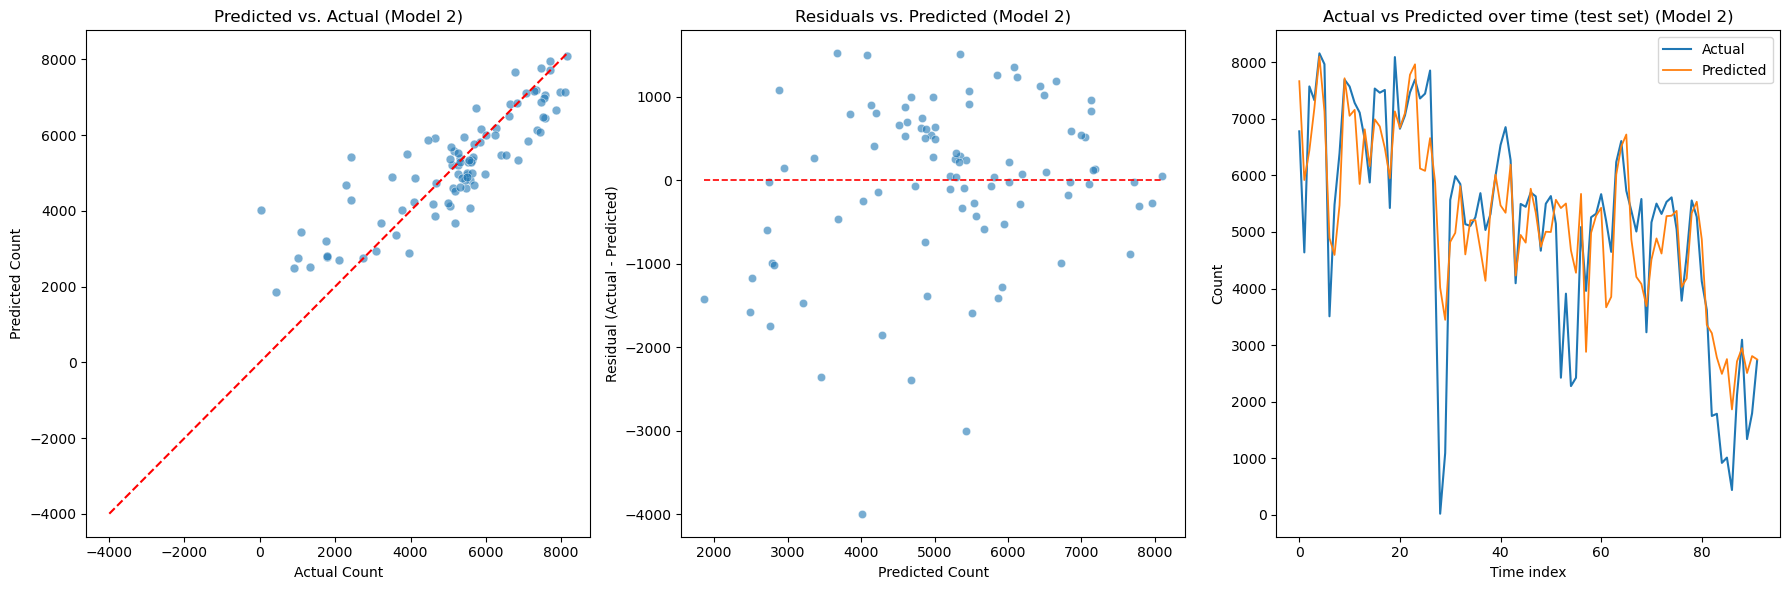

In [ ]:
results_refined = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
results_refined['Residuals'] = results_refined['Actual'] - results_refined['Predicted']


f, ax = plt.subplots(1,3, figsize=(18,6))

sns.scatterplot(data=results_refined, x="Actual", y="Predicted", alpha=.6, s=40, ax=ax[0])
sns.lineplot(x=[results_refined.min().min(), results_refined.max().max()],
             y=[results_refined.min().min(), results_refined.max().max()],
             color='red', linestyle='--', ax=ax[0])
ax[0].set_title('Predicted vs. Actual (Model 2)')
ax[0].set_xlabel("Actual Count")
ax[0].set_ylabel("Predicted Count")

sns.scatterplot(data=results_refined, x='Predicted', y="Residuals", alpha=.6, ax=ax[1])   
sns.lineplot(x=[results_refined["Predicted"].min(), results_refined["Predicted"].max()], y=[0,0], color='red', linestyle='--', linewidth=1.2, ax=ax[1])
ax[1].set_title('Residuals vs. Predicted (Model 2)')
ax[1].set_xlabel("Predicted Count")
ax[1].set_ylabel("Residual (Actual - Predicted)")


sns.lineplot(x=range(len(y_test)), y=y_test, label='Actual', linewidth=1.5, ax=ax[2])
sns.lineplot(x=range(len(y_test)), y=y_pred, label='Predicted', linewidth=1.3, ax=ax[2])
ax[2].set_title('Actual vs Predicted over time (test set) (Model 2)')
ax[2].set_xlabel('Time index')
ax[2].set_ylabel('Count')


ax[2].legend()
plt.tight_layout()
plt.show()

### Refined értékelése

- A validációs hibák (RMSE, MAE) csökkentek a baseline-hoz képest, és az időbeli predikciók stabilabbak.
- A magasabb értéktartományban (6000–8000 körül) enyhe alulbecslés,
míg az alacsonyabb tartományban (0–4000 között) inkább felülbecslés figyelhető meg. Ez arra utal, hogy a modell kiegyenlíti a szélsőségeket, és hajlamos középérték felé húzni.
- A reziduumok eloszlása véletlenszerűbb, nem mutat jól látható mintázatot,
ami arra utal, hogy a modell hibái nagyrészt zaj jellegűek, nem szisztematikusak.

---

### Jövőbeli lehetőségek és célok

A projekt során sikerült egy működő modellt építeni, ami jól követi a kerékpárbérlések időbeli és szezonális mintázatait.  
A modell teljesítménye összességében stabil, de több irányban is van lehetőség a fejlesztésre.

**Lehetséges továbblépések:**
- **Idősoros validáció (TimeSeriesSplit)** használata, hogy jobban lássuk, mennyire tud a modell alkalmazkodni a jövőbeli adatokhoz.  
- **További jellemzők bevonása**, például időjárási részletek vagy különleges napok (ünnepek, események), amik befolyásolhatják a bérléseket.  
- **Több modell kipróbálása**, például XGBoost vagy LightGBM, hogy összehasonlítható legyen a teljesítményük a mostani megoldással.  
- **Hyperparaméterek finomhangolása**, hogy a modell pontosabb és stabilabb legyen.  
- **Feature hatások elemzése különböző időszakokban**, hogy kiderüljön, mely tényezők maradnak fontosak hosszabb távon is.

**Összefoglalva:**  
A modell jó alapot ad, de a következő cél az időbeli stabilitás és a pontosság további javítása lesz, főleg ha a rendszert valódi előrejelzési feladatokra szeretnénk használni.
